In [8]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
train_dir = 'cats_and_dogs/train'
validation_dir = 'cats_and_dogs/validation'
test_dir = 'cats_and_dogs/test'


total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [10]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])


class CatsAndDogsDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        if directory == test_dir:
            self.files = [os.path.join(directory, f) for f in os.listdir(directory)]
        else:
            self.files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(directory) for f in filenames]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        if self.directory == test_dir:
            return img
        else:
            label = 1 if 'dog' in img_path[img_path.rfind('\\') + 1:] else 0
            return img, label

In [11]:
train_ds = CatsAndDogsDataset(train_dir, transform=transform)
val_ds = CatsAndDogsDataset(validation_dir, transform=transform)
test_ds = CatsAndDogsDataset(test_dir, transform=transform)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

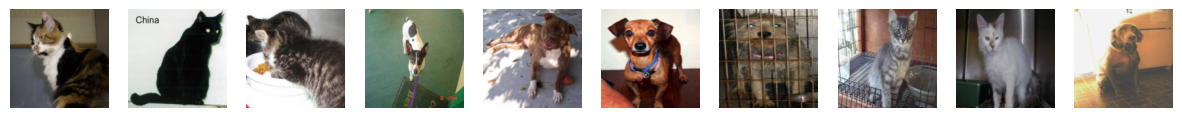

In [12]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(15,15))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img.numpy().transpose((1, 2, 0)))
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()


images, labels = next(iter(train_dl))
plotImages(images[:10], probabilities=False)

In [13]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.left = nn.Sequential(
            nn.Conv2d(3, 256, 5, stride = 2, padding = 0),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.Dropout(p=0.4),
            nn.Conv2d(256, 128, 3, stride = 2, padding = 0),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Dropout(p=0.4),
            )
        
        self.right = nn.Sequential(
            nn.Conv2d(3, 128, 10, stride = 4, padding = 0),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Dropout(p=0.4)
        )

        self.centre = nn.Sequential(
            nn.Flatten(),
            nn.Linear(165888, 32),
            nn.PReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        left = self.left(x)
        right = self.right(x)
        x = self.centre(left + right)
        return x
    
model = MyResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

def train(model, criterion, optimizer, train_dl, val_dl, epochs=5):
    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        success = 0
        for i, data in enumerate(train_dl):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, dim=1)
            success += torch.sum(preds == labels).item()
            running_loss += loss.item()
        train_loss = running_loss / len(train_dl)
        train_accuracy.append(success / len(train_ds))
        train_losses.append(train_loss)
        

        model.eval()
        running_loss = 0.0
        with torch.inference_mode():
            success = 0
            for i, data in enumerate(val_dl):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)
                success += torch.sum(preds == labels).item()
                running_loss += loss.item()
            val_loss = running_loss / len(val_dl)
            val_accuracy.append(success / len(val_ds))
            val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} : Training loss: {train_loss}, Validation loss: {val_loss}, Training accuracy: {train_accuracy[-1]}, Validation accuracy: {val_accuracy[-1]}')
    return train_losses, val_losses

train_losses, val_losses = train(model, criterion, optimizer, train_dl, val_dl, epochs=epochs)

Epoch 1/15 : Training loss: 0.7050519101321697, Validation loss: 0.6868869885802269, Training accuracy: 0.5285, Validation accuracy: 0.553
Epoch 2/15 : Training loss: 0.6492935456335545, Validation loss: 0.6636981517076492, Training accuracy: 0.6105, Validation accuracy: 0.614
Epoch 3/15 : Training loss: 0.6222369447350502, Validation loss: 0.662730872631073, Training accuracy: 0.6535, Validation accuracy: 0.604
Epoch 4/15 : Training loss: 0.5938660502433777, Validation loss: 0.6246544346213341, Training accuracy: 0.689, Validation accuracy: 0.64
Epoch 5/15 : Training loss: 0.5730492956936359, Validation loss: 0.6181355193257332, Training accuracy: 0.7065, Validation accuracy: 0.653
Epoch 6/15 : Training loss: 0.5323084592819214, Validation loss: 0.6145223379135132, Training accuracy: 0.7295, Validation accuracy: 0.658
Epoch 7/15 : Training loss: 0.5160687174648046, Validation loss: 0.6334648728370667, Training accuracy: 0.7515, Validation accuracy: 0.651
Epoch 8/15 : Training loss: 0.

In [14]:
def test(model, test_dl):
    model.eval()
    predictions = []
    for i, data in enumerate(test_dl):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
    return np.array(predictions)

In [15]:
answers =  np.array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0])

predictions = test(model, test_dl)
print("Accuracy: ", np.mean(predictions == answers)*100)

Accuracy:  74.0
